# Load datasets

In [9]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import random
import os

import FSHA_torch
# import architectures_torch as architectures
import datasets_torch
from datasets_torch import *

seed = 42
seed = int(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


In [11]:
data_name = 'cifar'
if data_name == 'cifar' :

    xpriv, xpub = load_cifar()

elif data_name == 'mnist' :
    xpriv, xpub = load_mnist()

n = 15
x_priv = torch.from_numpy(getImagesDS(xpriv, n))
x_pub = torch.from_numpy(getImagesDS(xpub, n))


Files already downloaded and verified


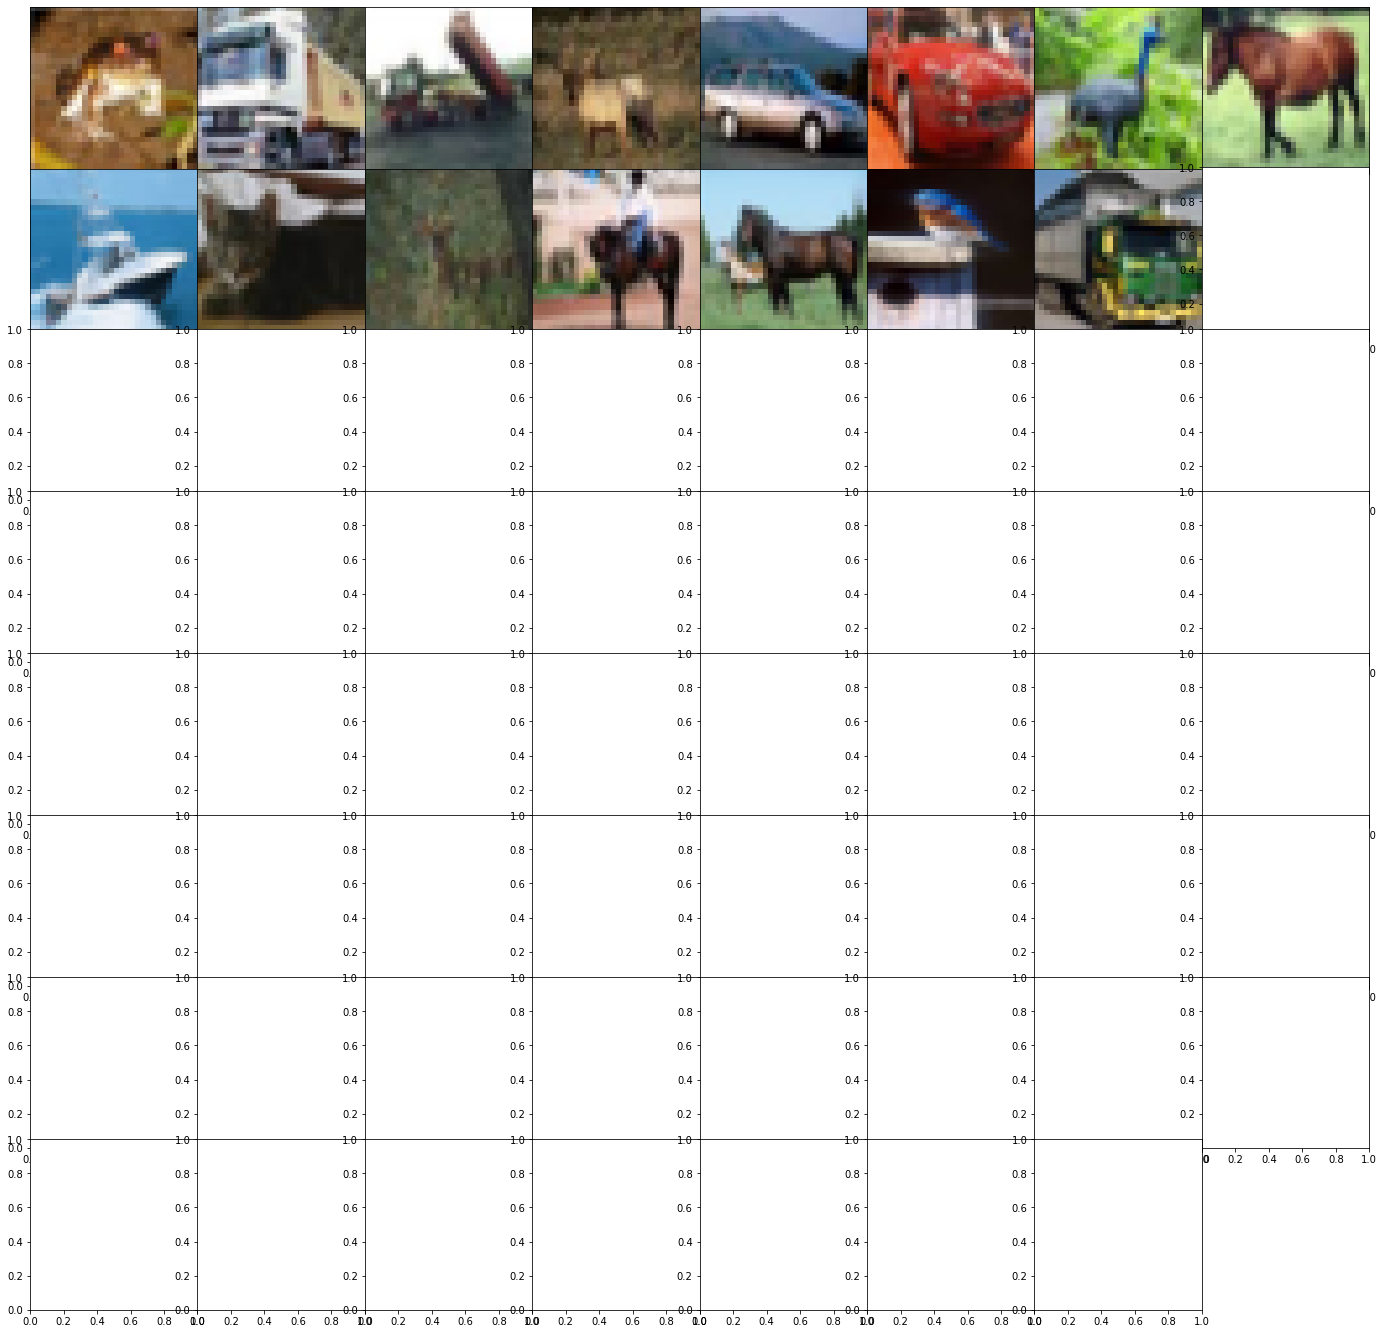

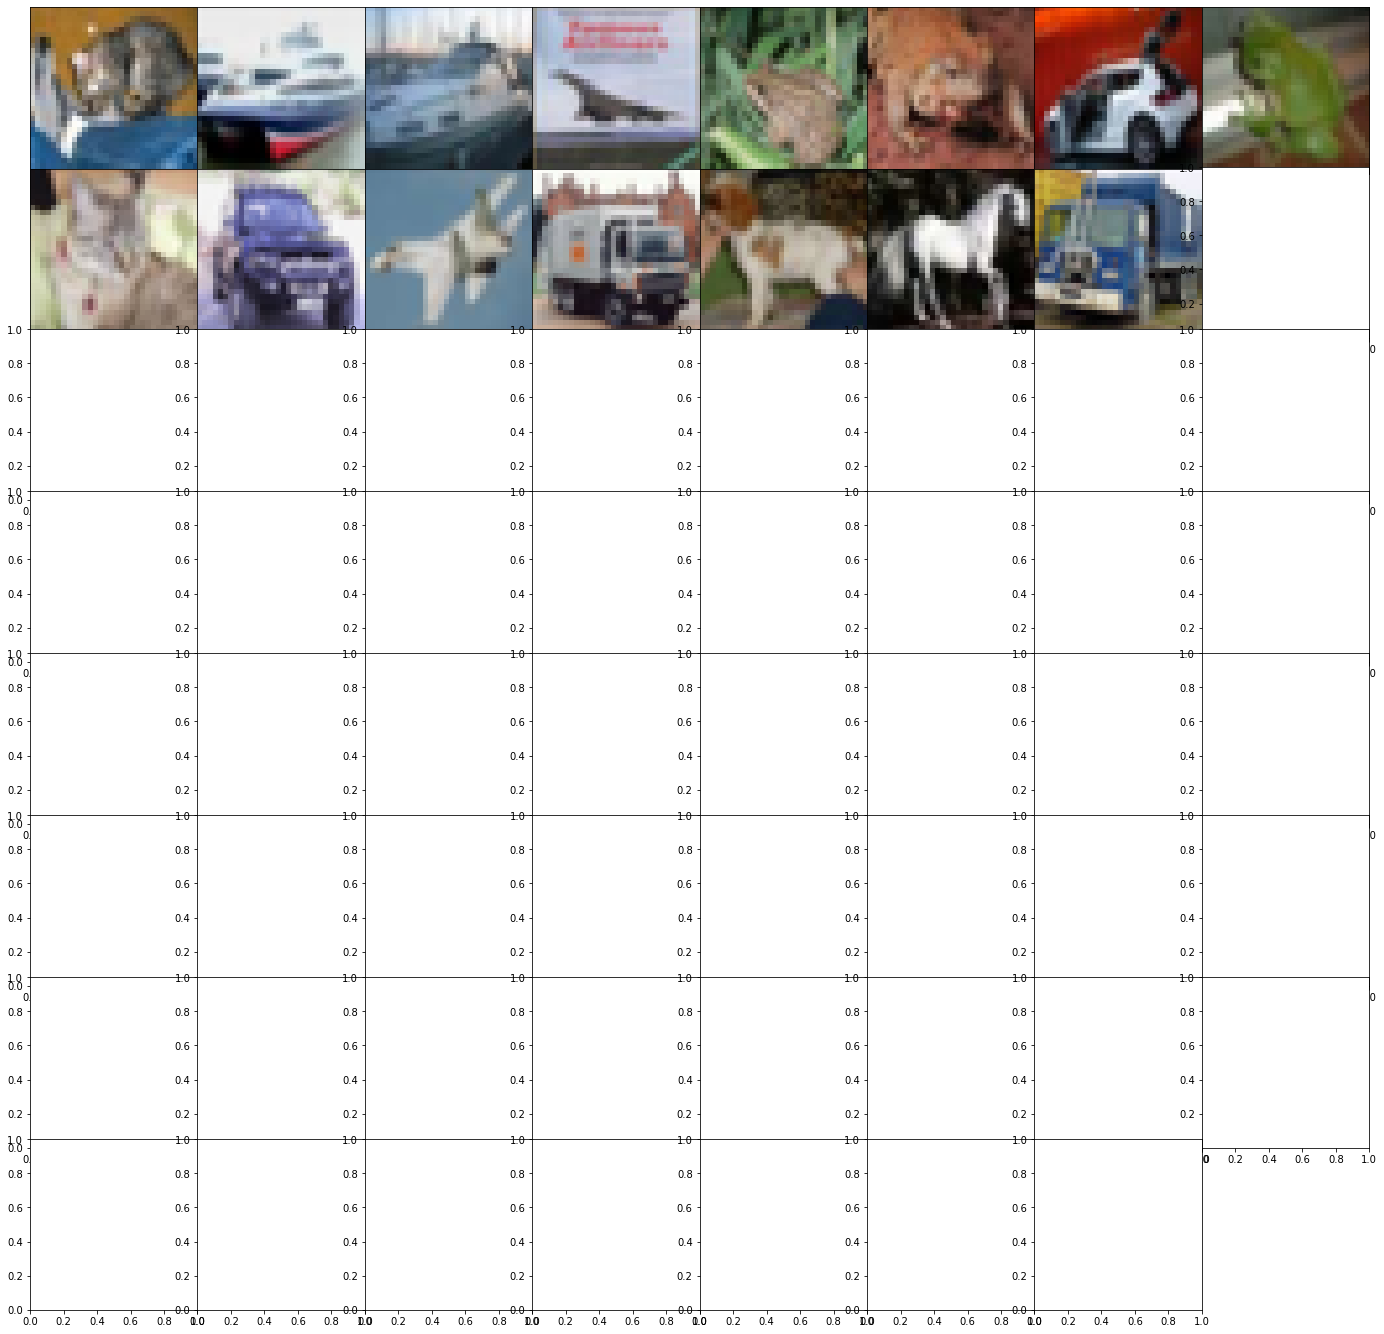

In [12]:
def plot(X):
    n = len(X)
    #print(n)
    #X = (X+1)/2
    fig, ax = plt.subplots(8, 8, figsize=(8*3,8*3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i//8, i%8].imshow(X[i]) 
        #print(X[i].shape)
        ax[i//8, i%8].set(xticks=[], yticks=[])
        ax[i//8, i%8].set_aspect('equal')
        
    return fig
x_priv_show = (x_priv+1)/2
x_priv_show = x_priv_show.detach().permute(0,2,3,1).numpy()
#print(x_priv_show[0].shape)
fig = plot(x_priv_show)
x_pub_show = (x_pub+1)/2
x_pub_show = x_pub_show.detach().permute(0,2,3,1).numpy()
fig = plot(x_pub_show)
#fig = plot(X)

# Setup attack:

In [13]:
batch_size = 64
id_setup = 1
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}

fsha = FSHA_torch.FSHA(xpriv, xpub, id_setup-1, batch_size, hparams)

[PILOT] activation:  None
torch.Size([64, 16, 16])
[DECODER] activation:  None


# Run attack:

In [14]:
log_frequency = 500
LOG = fsha(10000, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...


  0%|          | 1/10000 [00:00<1:21:48,  2.04it/s]

log--00%-0000000] validation: 0.3404
f_Loss: -0.8324575424194336
f_tilde_loss: 0.25750550627708435
D_loss: 23.13321876525879



  5%|▌         | 501/10000 [03:45<1:10:08,  2.26it/s]

log--05%-0000500] validation: 0.2138
f_Loss: 47.327186584472656
f_tilde_loss: 0.034532781690359116
D_loss: -36.61431884765625



 10%|▉         | 989/10000 [07:29<1:08:17,  2.20it/s]


KeyboardInterrupt: 

# Plot logs:

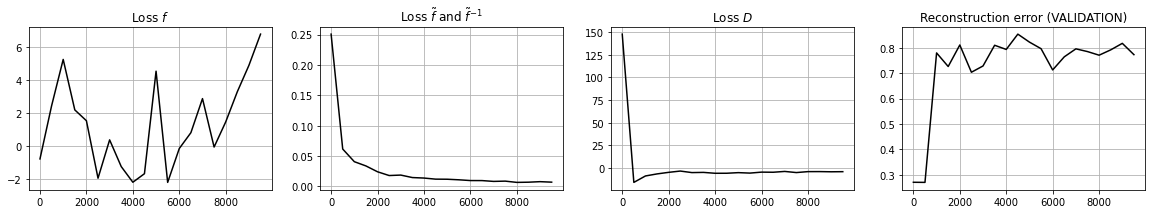

In [7]:
def plot_log(ax, x, y, label):
    ax.plot(x, y, color='black')
    ax.set(title=label)
    ax.grid()

n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 3))
x = np.arange(0, len(LOG)) * log_frequency 

plot_log(ax[0], x, LOG[:, 0], label='Loss $f$')
plot_log(ax[1], x, LOG[:, 1],  label='Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$')
plot_log(ax[2], x, LOG[:, 2],  label='Loss $D$')
plot_log(ax[3], x, LOG[:, 3],  label='Reconstruction error (VALIDATION)')

# Plot reconstruction private data:

In [8]:
n = 10
X = torch.from_numpy(getImagesDS(xpriv, n)).cuda()
X_recovered, control = fsha.attack(X)
X = (X+1)/2
X_recovered = (X_recovered+1)/2
#print(X.shape)
#print(X_recovered.shape)
#print(X[0])


In [9]:
import pytorch_msssim
from pytorch_msssim import ssim
#print(results[0])

sum = 0
for i in range(n):
    target = X[i].unsqueeze(0)
    result = X_recovered[i].unsqueeze(0)
    #print(target)
    ssim_value = ssim(target.to('cpu'), result.to('cpu'), data_range=1.0, size_average=True, nonnegative_ssim=True)
    print(ssim_value)
    sum = sum + ssim_value

average_ssim = sum/n
print(f'ssim:{average_ssim}')

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
ssim:0.0


In [10]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') 
loss_fn_vgg = lpips.LPIPS(net='vgg')
sum1 = 0
sum2 = 0
for i in range(n):
    target = X[i].unsqueeze(0)
    result = X_recovered[i].unsqueeze(0)
    lpips_alex = loss_fn_alex(target.to('cpu'), result.to('cpu'))
    lpips_vgg = loss_fn_vgg(target.to('cpu'), result.to('cpu'))
    print(lpips_alex)
    print(lpips_vgg)
    sum1 = sum1 + lpips_alex
    sum2 = sum2 + lpips_vgg

average_lpips_alex = sum1/n
average_lpips_vgg = sum2/n
print(f'lpips_alex:{average_lpips_alex}')
print(f'lpips_vgg:{average_lpips_vgg}')   

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /root/miniconda3/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
tensor([[[[0.0723]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4263]]]], grad_fn=<AddBackward0>)
tensor([[[[0.0732]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4489]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1170]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4776]]]], grad_fn=<AddBackward0>)
tensor([[[[0.0941]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4793]]]], grad_fn=<AddBackward0>)
tensor([[[[0.0889]]]], grad_fn=<AddBackward0>)
tensor([[[[0.5141]]]], grad_fn=<AddBackward0>)
tensor([[[[0.0629]]]], grad_fn=<AddBackward0>)
tensor([[[[0.4398]]]], grad_fn=<AddBackward0>)
tensor([[[[0.0541]]]], grad_fn=<AddBackward0>)
tensor([[[[0.3760]]]], grad_fn=<AddBackward0>)
tensor([[[[0.0

(10, 32, 32, 3)


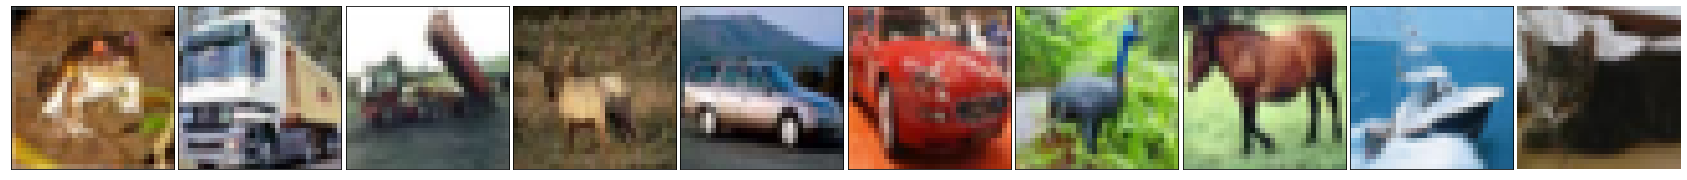

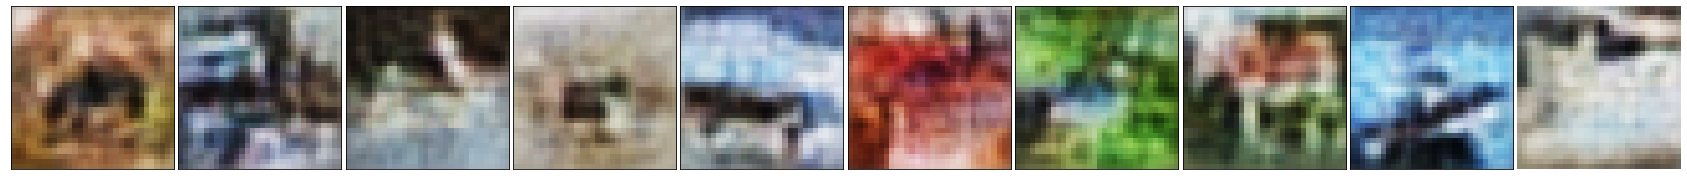

In [11]:
X = X.detach().cpu().permute(0,2,3,1).numpy()
X_recovered = X_recovered.detach().cpu().permute(0,2,3,1).numpy()

print(X.shape)
#print(X_recovered.shape)
def plot(X):
    n = len(X)
    #X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]));  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X)
fig = plot(X_recovered)